In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score

In [2]:
# Load the datasets
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")

In [3]:
# Preview the datasets
print("Customers dataset preview:")
print(customers.head())

print("\nProducts dataset preview:")
print(products.head())

print("\nTransactions dataset preview:")
print(transactions.head())

Customers dataset preview:
  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15

Products dataset preview:
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31

Transactions dataset preview:
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54        

In [16]:
# Merge datasets for a comprehensive view
merged_data = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')
print("\nMerged data preview:")
print(merged_data.head())


Merged data preview:
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue  Price_x     CustomerName         Region  SignupDate  \
0      300.68   300.68   Andrea Jenkins         Europe  2022-12-03   
1      300.68   300.68  Brittany Harvey           Asia  2024-09-04   
2      300.68   300.68  Kathryn Stevens         Europe  2024-04-04   
3      601.36   300.68  Travis Campbell  South America  2024-04-11   
4      902.04   300.68    Timothy Perez         Europe  2022-03-15   

                       ProductName     Category  Price_y  
0  ComfortLiving Bluetooth Speaker  Electronics   300.68  
1  ComfortLi

In [18]:
# Inspect column names
print("Merged data columns:")
print(merged_data.columns)

# Check for 'Price' column
if 'Price' not in merged_data.columns:
    print("\nThe 'Price' column is not found in the merged data.")
    print("Available columns:", merged_data.columns)
    # Update this to the correct column name based on the dataset
else:
    # Ensure numeric conversion
    merged_data['Price'] = pd.to_numeric(merged_data['Price'], errors='coerce')
    print("Price column successfully processed.")


Merged data columns:
Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'Price_x', 'CustomerName', 'Region',
       'SignupDate', 'ProductName', 'Category', 'Price_y'],
      dtype='object')

The 'Price' column is not found in the merged data.
Available columns: Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'Price_x', 'CustomerName', 'Region',
       'SignupDate', 'ProductName', 'Category', 'Price_y'],
      dtype='object')


In [20]:
# Inspect the Price columns and use the relevant one
merged_data['Price'] = pd.to_numeric(merged_data['Price_y'], errors='coerce')  # Using Price_y from Products.csv

# Optionally drop the unused Price column
merged_data = merged_data.drop(columns=['Price_x'])

# Check the processed dataset
print("\nUpdated merged data columns:")
print(merged_data.columns)



Updated merged data columns:
Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'CustomerName', 'Region', 'SignupDate',
       'ProductName', 'Category', 'Price_y', 'Price'],
      dtype='object')


In [21]:
# Ensure numeric columns are correctly formatted
merged_data['TotalValue'] = pd.to_numeric(merged_data['TotalValue'], errors='coerce')
merged_data['Price'] = pd.to_numeric(merged_data['Price'], errors='coerce')

# Feature Engineering

In [22]:
# 1. Calculate total transaction value per customer
customer_total_spent = merged_data.groupby('CustomerID')['TotalValue'].sum().reset_index()
customer_total_spent.rename(columns={'TotalValue': 'TotalSpent'}, inplace=True)


In [23]:
# 2. Count total transactions per customer
customer_transaction_count = merged_data.groupby('CustomerID')['TransactionID'].count().reset_index()
customer_transaction_count.rename(columns={'TransactionID': 'TransactionCount'}, inplace=True)

In [24]:
# 3. Average transaction value per customer
customer_avg_transaction_value = merged_data.groupby('CustomerID')['TotalValue'].mean().reset_index()
customer_avg_transaction_value.rename(columns={'TotalValue': 'AvgTransactionValue'}, inplace=True)

# 4. Merge the features
customer_features = customers.merge(customer_total_spent, on='CustomerID')
customer_features = customer_features.merge(customer_transaction_count, on='CustomerID')
customer_features = customer_features.merge(customer_avg_transaction_value, on='CustomerID')

# 5. Drop unnecessary columns
customer_features = customer_features.drop(columns=['CustomerName', 'SignupDate'])


In [25]:
# Preview customer features
print("\nCustomer features for clustering:")
print(customer_features.head())


Customer features for clustering:
  CustomerID         Region  TotalSpent  TransactionCount  AvgTransactionValue
0      C0001  South America     3354.52                 5              670.904
1      C0002           Asia     1862.74                 4              465.685
2      C0003  South America     2725.38                 4              681.345
3      C0004  South America     5354.88                 8              669.360
4      C0005           Asia     2034.24                 3              678.080


# Preprocessing

In [26]:
# Preprocessing
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features.drop(columns=['CustomerID', 'Region']))



Optimal number of clusters (based on DB Index): 5
DB Index values for each K: [1.0072253641525208, 0.9578205962311453, 1.0604240399923033, 0.8524813520458038, 0.8693770662816185, 0.8553114327404956, 0.9125320039336968, 0.8847550123525418, 0.8630460126564934]


<ipython-input-27-19cfbb4fd1c1>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(k_values), y=db_scores, palette="viridis")


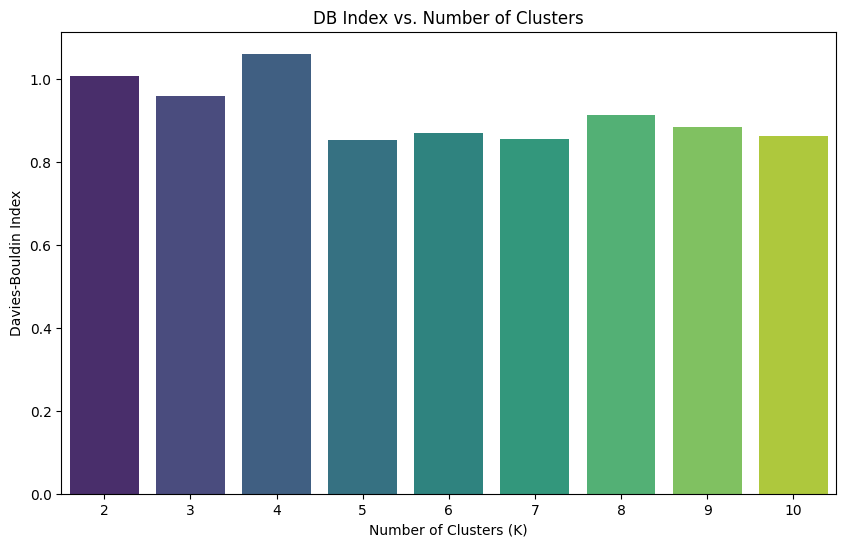

In [27]:
# Clustering using K-Means
db_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    db_index = davies_bouldin_score(scaled_features, labels)
    db_scores.append(db_index)

# Find optimal K based on Davies-Bouldin Index
optimal_k = k_values[np.argmin(db_scores)]
print(f"\nOptimal number of clusters (based on DB Index): {optimal_k}")
print(f"DB Index values for each K: {db_scores}")

# Fit K-Means with optimal K
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(scaled_features)

# Visualizing the DB Index vs. K
plt.figure(figsize=(10, 6))
sns.barplot(x=list(k_values), y=db_scores, palette="viridis")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Davies-Bouldin Index")
plt.title("DB Index vs. Number of Clusters")
plt.show()

# PCA

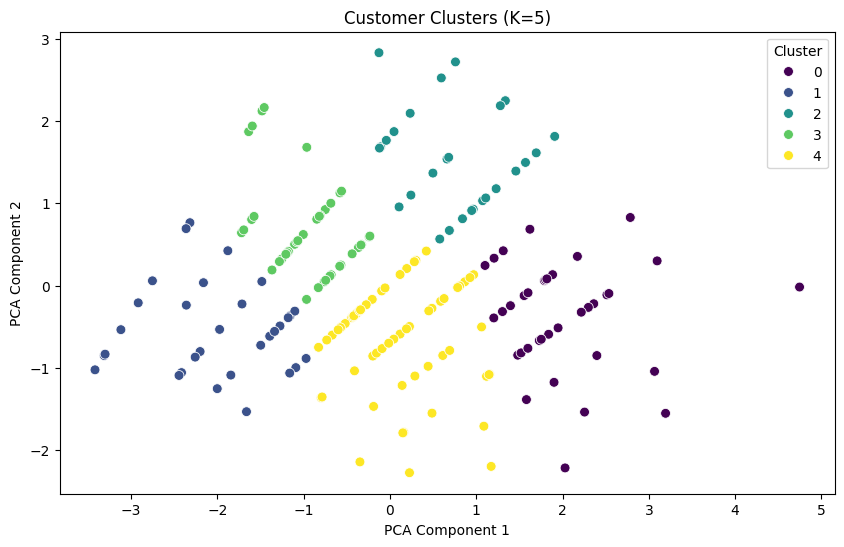

In [28]:
# PCA for visualization (2D Plot)
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=customer_features['Cluster'], palette='viridis', s=50)
plt.title(f"Customer Clusters (K={optimal_k})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

In [30]:
# Final cluster statistics
cluster_summary = customer_features.groupby('Cluster')[['TotalSpent', 'TransactionCount', 'AvgTransactionValue']].mean()  # Selecting only numeric columns for mean calculation
print("\nCluster Summary:")
print(cluster_summary)


Cluster Summary:
          TotalSpent  TransactionCount  AvgTransactionValue
Cluster                                                    
0        6236.275278          7.888889           800.215188
1        1125.417419          2.935484           372.112215
2        4327.404815          4.111111          1066.046222
3        2163.799024          3.048780           730.433882
4        3516.344062          6.078125           589.909275


In [34]:
# Save the results
customer_features.to_csv("Customer_Clusters.csv", index=False)
print("\nCustomer clusters saved to 'Customer_Clusters.csv'")


Customer clusters saved to 'Customer_Clusters.csv'


In [36]:
# Assuming 'final_data' is the dataset used for clustering and 'clusters' contains the labels
# In your case, 'customer_features' is likely the dataset you used for clustering
final_data = customer_features  # Replacing 'final_data' with 'customer_features'
final_data['Cluster'] = labels  # Add cluster labels to the dataset, replacing 'clusters' with 'labels'

# Summarizing the cluster characteristics
cluster_data = final_data.groupby('Cluster').agg({
    'TotalSpent': 'mean',  # Average total spending per cluster
    'TransactionCount': 'mean',  # Average transaction count per cluster
    'CustomerID': 'count'  # Number of customers per cluster
}).reset_index()

cluster_data.rename(columns={'CustomerID': 'CustomerCount'}, inplace=True)

<ipython-input-37-732a65d7a35c>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=customer_counts.index, y=customer_counts.values, palette='viridis')


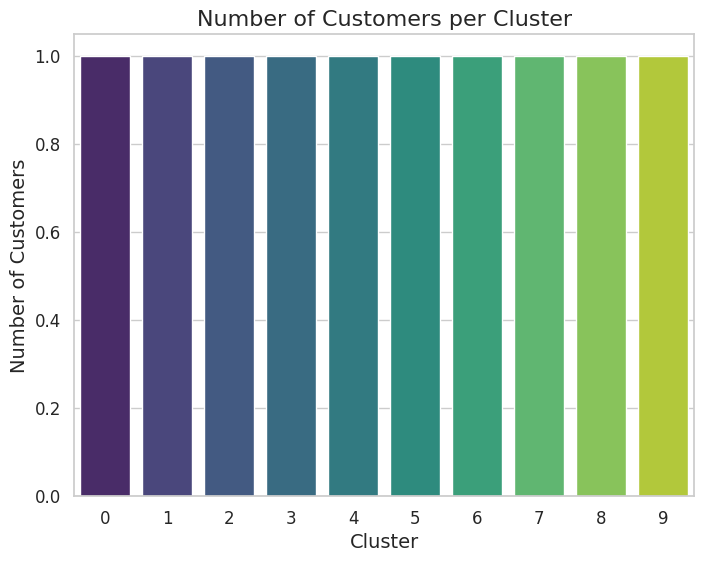

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='whitegrid')

# Count of customers per cluster
customer_counts = cluster_data['Cluster'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
sns.barplot(x=customer_counts.index, y=customer_counts.values, palette='viridis')
plt.title('Number of Customers per Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Number of Customers', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


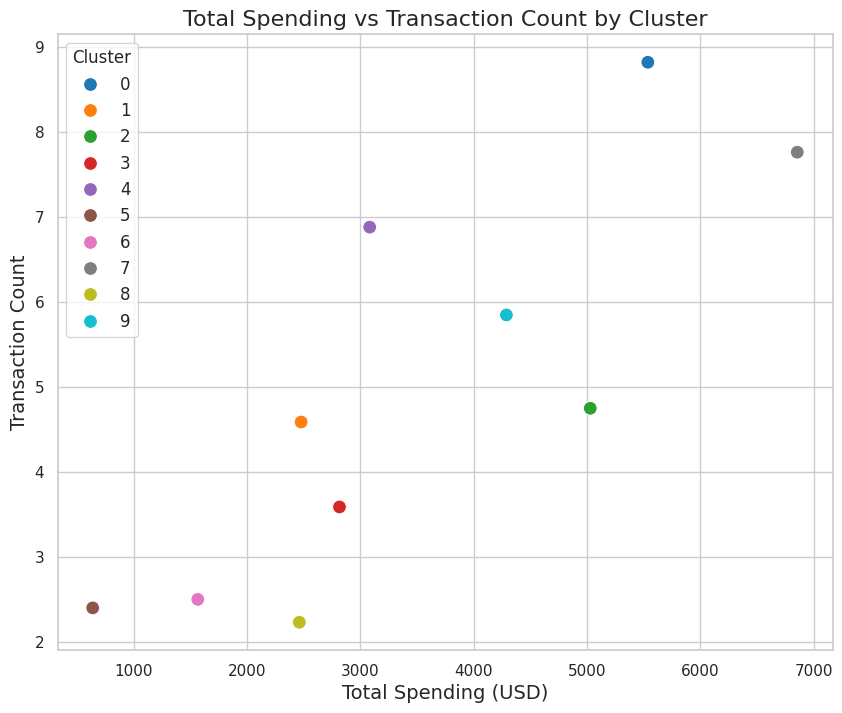

In [38]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=cluster_data, x='TotalSpent', y='TransactionCount', hue='Cluster', palette='tab10', s=100
)
plt.title('Total Spending vs Transaction Count by Cluster', fontsize=16)
plt.xlabel('Total Spending (USD)', fontsize=14)
plt.ylabel('Transaction Count', fontsize=14)
plt.legend(title='Cluster', fontsize=12)
plt.grid(True)
plt.show()
